In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import xarray as xr

Cargamos los datos y los almacenamos en arrays diviendolos en meses y variables para poder luego usar PCA:

In [3]:
# Cargar el dataset NetCDF (en este caso solo el de zonas terrestres)
ds = xr.open_dataset("ensemble_modelos_land.nc")

variables = ['clt_ensemble_mean', 'pr_ensemble_mean', 'rsds_ensemble_mean', 'sfcWind_ensemble_mean', 'tas_ensemble_mean']
meses = ds['month'].values

arrays_dict = {}

# Usamos una variable base para crear la máscara de tierra
var_base = 'tas_ensemble_mean'
mask_tierra = ~np.isnan(np.squeeze(ds[var_base].isel(month=0).values))  # True donde hay tierra

# Crear coordenadas completas
latitudes = ds['lat'].values
longitudes = ds['lon'].values
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Aplicar máscara a las coordenadas → solo tierra
array_coord = np.column_stack([lat_grid[mask_tierra], lon_grid[mask_tierra]])

# Recorrer meses y variables aplicando la misma máscara
for mes in np.unique(meses):
    for var in variables:
        datos_mes = np.squeeze(ds[var].sel(month=mes).values)
        datos_mes_tierra = datos_mes[mask_tierra]  # solo valores terrestres
        arrays_dict[f"mes_{int(mes)}_{var}"] = datos_mes_tierra

# Verificación
print(f"Se generaron {len(arrays_dict)} arrays en el diccionario.")
print("Ejemplo de claves:", list(arrays_dict.keys())[:6])
print("Ejemplo de coordenadas:\n", array_coord[:5])
print("Tamaño de puntos terrestres:", len(array_coord))


Se generaron 60 arrays en el diccionario.
Ejemplo de claves: ['mes_1_clt_ensemble_mean', 'mes_1_pr_ensemble_mean', 'mes_1_rsds_ensemble_mean', 'mes_1_sfcWind_ensemble_mean', 'mes_1_tas_ensemble_mean', 'mes_2_clt_ensemble_mean']
Ejemplo de coordenadas:
 [[-55.13089005 290.        ]
 [-55.13089005 291.25      ]
 [-55.13089005 292.5       ]
 [-55.13089005 293.75      ]
 [-54.18848168 287.5       ]]
Tamaño de puntos terrestres: 7317


In [4]:
n_vars = len(arrays_dict)
first_len = len(next(iter(arrays_dict.values())))
print(f"Variables detectadas: {n_vars}")
print(f"Tamaño de cada vector: {first_len}")

assert all(len(v) == first_len for v in arrays_dict.values())

Variables detectadas: 60
Tamaño de cada vector: 7317


PCA:

In [5]:
n_features = n_vars
n_points = first_len

# Mantener el orden alfabético para reproducibilidad
keys_sorted = sorted(arrays_dict.keys())
X = np.vstack([arrays_dict[k] for k in keys_sorted])
print("Forma de la matriz original:", X.shape)

Forma de la matriz original: (60, 7317)


In [6]:
X_t = X.T 

In [7]:
print("Estandarizando datos ")
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_t)

Estandarizando datos 


In [8]:
pca = PCA(n_components=0.90)
X_reduced = pca.fit_transform(X_scaled)

print("Varianza explicada acumulada:", np.cumsum(pca.explained_variance_ratio_))
X_reduced.shape

X_reduced

print("Valores singulares:", pca.singular_values_)

Varianza explicada acumulada: [0.3709176  0.61902064 0.75633305 0.8747379  0.9097188 ]
Valores singulares: [72.41131  59.22209  44.057777 40.912163 22.237349]


Aplicamos K-means sobre los resultados de PCA:

In [9]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_reduced) 

Recontruir el mapa:

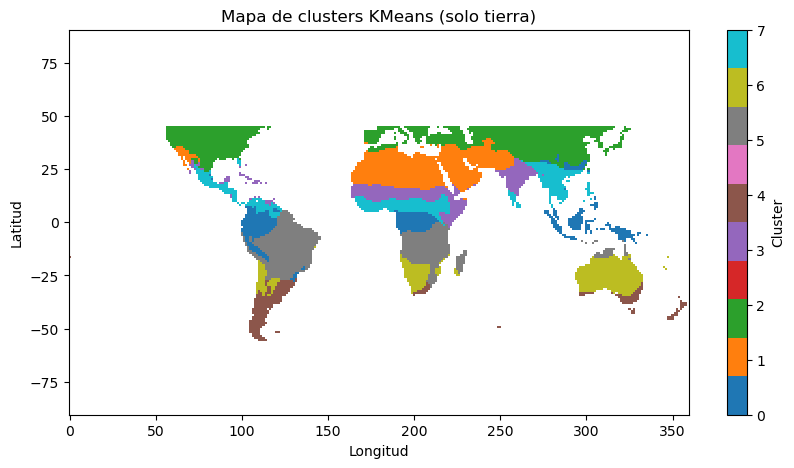

In [12]:
# Crear una matriz llena de NaN con el tamaño original del dataset
nlat = len(ds["lat"])
nlon = len(ds["lon"])
mapa_clusters = np.full((nlat, nlon), np.nan)

# Rellenar solo las posiciones terrestres
mapa_clusters[mask_tierra] = labels

# Convertirlo en un DataArray de xarray 
mapa_clusters_xr = xr.DataArray(
    mapa_clusters,
    coords={"lat": ds["lat"], "lon": ds["lon"]},
    dims=["lat", "lon"],
    name="clusters"
)

# Reordenar longitudes de -180 a 180
mapa_clusters_xr = mapa_clusters_xr.assign_coords(
    lon=(((mapa_clusters_xr.lon + 180) % 360) - 180)
).sortby("lon")

# Visualizar
plt.figure(figsize=(10,5))
plt.pcolormesh(ds["lon"], ds["lat"], mapa_clusters_xr, shading="auto", cmap="tab10")
plt.colorbar(label="Cluster")
plt.title("Mapa de clusters KMeans (solo tierra)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [13]:
# Guardar en archivo NetCDF
mapa_clusters_xr.to_netcdf("mapa_clusters.nc")

print("Archivo 'mapa_clusters.nc' guardado correctamente.")


Archivo 'mapa_clusters.nc' guardado correctamente.
